# Latent Space Models for Brain Networks


In [21]:
import os
import sys
import pickle
import datetime
sys.path.append(os.path.abspath(".."))

import numpy as np
import numpy.random as npr
from scipy.misc import logsumexp
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable, Grid
import matplotlib.gridspec as gridspec

%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("paper")
colors = sns.xkcd_palette(
    ["red",
     "windows blue",
     "amber",
     "faded green",
     "dusty purple",
     "orange",
     "clay",
     "midnight"
    ])

from tqdm import tqdm

from hips.plotting.layout import create_axis_at_location, remove_plot_labels
from hips.plotting.colormaps import gradient_cmap

from lsm import LatentSpaceModel, LatentSpaceModelWithShrinkage, \
    MixtureOfLatentSpaceModels, MixtureOfLatentSpaceModelsWithShrinkage, \
    FactorialLatentSpaceModel
    
from lsm.utils import random_mask, cached, white_to_color_cmap, logistic

### Store the model fits so that we don't have to rerun them all the time

In [2]:
# Override this if using an existing results directory
# results_dir = None
# results_dir = os.path.join("..", "results", "2017_06_16")
# results_dir = os.path.join("..", "results", "2017_08_02")
results_dir = os.path.join("..", "results", "2017_08_03")

if results_dir is None:
    # By default, store results in results/yyyy_mm_dd directory for today
    results_basedir = os.path.join("..", "results")
    assert os.path.exists(results_basedir), "'results' directory must exist in project root."

    today = datetime.date.today()
    results_dir = os.path.join(results_basedir, today.strftime("%Y_%m_%d"))
    if not os.path.exists(results_dir):
        print("Making directory for today's results: ", results_dir)
        os.mkdir(results_dir)

In [3]:
missing_frac = 0.25
N_itr = 500
Ks = np.arange(2, 21, 2, dtype=int)
H = 10
sigmasq_b = 1.0

In [4]:
# Load the KKI-42 dataset
datapath = os.path.join("..", "data", "kki-42-data.pkl")
assert os.path.exists(datapath)
with open(datapath, "rb") as f:
    As = pickle.load(f)

N, Vorig, _ = As.shape
assert N == 42 and Vorig == 70 and As.shape[2] == Vorig
bad_indices = [0, 35]
good_indices = np.array(sorted(list(set(np.arange(Vorig)) - set(bad_indices))))
As = As[np.ix_(np.arange(N), good_indices, good_indices)]
V = Vorig - len(bad_indices)

# Sample random masks
masks = [random_mask(V, missing_frac) for _ in range(N)]

# Compute number of train/test edges
L = np.tril(np.ones((V, V), dtype=bool), k=-1)
N_train = np.sum([mask * L for mask in masks])
N_test = np.sum([(1- mask) * L for mask in masks])

print("N: ", N)
print("V: ", V)
print("Num edges: ", N * V * (V-1) / 2)
print("Num train: ", N_train)
print("Num test:  ", N_test)

N:  42
V:  68
Num edges:  95676.0
Num train:  71614
Num test:   24062


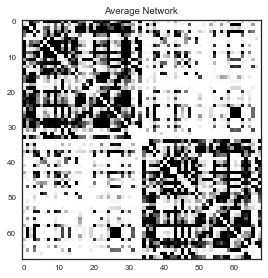

In [5]:
# Plot the mean network
plt.imshow(As.mean(0), vmin=0, vmax=1, interpolation="nearest")
plt.title("Average Network")

# Fit the models

In [6]:
def fit(model, N_init_itr=0):
    print("Fitting ", model.name)
    lprs = []
    lls = []
    hlls = []
    ms = []
    
    # Burnin by sampling X and b only
    print("Running {} initialization iterations.".format(N_init_itr))
    for itr in tqdm(range(N_init_itr)):
        model._resample_X()
        model._resample_b()
    
    print("Running {} sampling iterations.".format(N_itr))
    for itr in tqdm(range(N_itr)):
        model.resample()
        lprs.append(model.log_prior())
        assert np.isscalar(lprs[-1])
        lls.append(model.log_likelihood())
        hlls.append(model.heldout_log_likelihood())
        ms.append(model.ms.copy())
    return model, np.array(lprs), np.array(lls), np.array(hlls), np.array(ms)

def fit_list(models, **kwargs):
    results = []
    for model in models:
        for A, mask in zip(As, masks):
            model.add_data(A, mask=mask)
        model.initialize()
        
        _fit = cached(results_dir, model.name)(fit)
        results.append(_fit(model, **kwargs))
    return results

In [7]:
# Baseline model
baseline_model, baseline_lprs, baseline_lls, baseline_hlls, _  = \
    fit_list([LatentSpaceModel(V, 0, name="bernoulli")])[0]
baseline_ll = np.mean(baseline_lls[N_itr//2:])
baseline_hll = np.mean(baseline_hlls[N_itr//2:])

In [8]:
# Standard model
std_models = []
for K in Ks:
    std_models.append(LatentSpaceModel(V, K, sigmasq_b=sigmasq_b))
std_results = fit_list(std_models)

In [9]:
# Standard model with shrinkage prior
std_shr_models = []
for K in Ks:
    std_shr_models.append(
        LatentSpaceModelWithShrinkage(V, K, sigmasq_b=sigmasq_b, 
            sigmasq_prior_prms=dict(a1=2.5, a2=3.5)))
std_shr_results = fit_list(std_shr_models)

[  2.53858510e+00   3.71476212e+00   2.84649257e+00   1.95030590e+00
   2.43102283e+00   1.28311668e+00   1.20676513e+00   1.24634743e+00
   1.29246203e+00   2.79399743e-01   1.76457386e-02   1.32843737e-03
   8.87666327e-05   9.04557045e-06   1.05431608e-06   8.80123485e-08
   1.86267954e-08   3.06477547e-09   5.67456438e-10   1.87460276e-10]


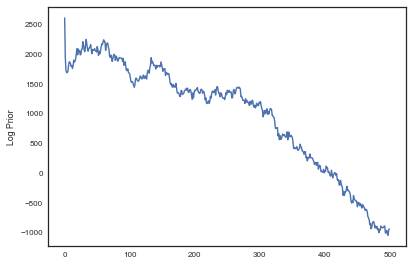

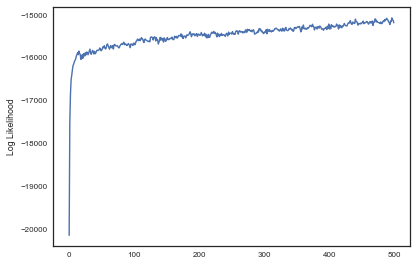

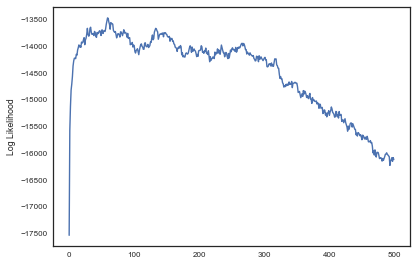

In [10]:
print(std_shr_results[-1][0].sigmasq_x)

plt.figure()
plt.plot(std_shr_results[-1][1])
plt.ylabel("Log Prior")

plt.figure()
plt.plot(std_shr_results[-1][2])
plt.ylabel("Log Likelihood")

plt.figure()
plt.plot(std_shr_results[-1][1] + std_shr_results[-1][2])
plt.ylabel("Log Likelihood")

In [11]:
# Mixture of latent space models 
mix_models = []
for K in Ks:
    mix_models.append(MixtureOfLatentSpaceModels(V, K*H, H=H, sigmasq_b=sigmasq_b))
mix_results = fit_list(mix_models, N_init_itr=20)

[7, 1, 6, 9, 7, 8, 1, 2, 6, 9, 9, 1, 1, 1, 1, 0, 1, 1, 1, 8, 9, 6, 6, 1, 7, 1, 6, 7, 2, 3, 7, 5, 3, 1, 0, 5, 1, 1, 4, 7, 4, 6]


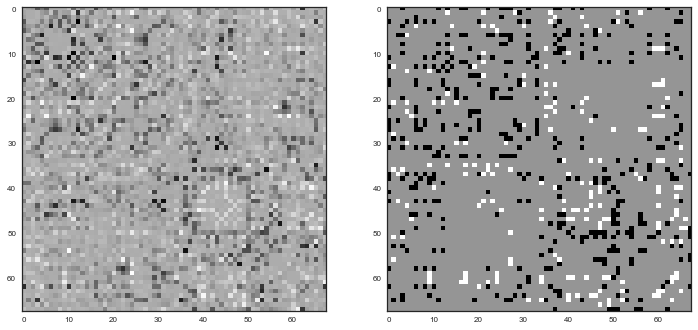

In [12]:
# plt.imshow(np.array(mix_results[-1][0].ms))
print(mix_results[-1][0].hs)
# plt.subplot(121)
# plt.imshow(mix_results[-1][0].edge_probabilities(0))
# plt.subplot(122)
# plt.imshow(mix_results[-1][0].edge_probabilities(1))
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(mix_results[-1][0].edge_probabilities(0) - mix_results[-1][0].edge_probabilities(1))
plt.subplot(122)
plt.imshow(As[0].astype(float) - As[1].astype(float))

In [13]:
# Mixture of latent space models with shrinkage prior
mix_shr_models = []
for K in Ks:
    mix_shr_models.append(
        MixtureOfLatentSpaceModelsWithShrinkage(
            V, K*H, H=H, sigmasq_b=sigmasq_b, 
            sigmasq_prior_prms=dict(a1=2.5, a2=3.5)))
mix_shr_results = fit_list(mix_shr_models, N_init_itr=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Fitting  molsm_shrink_K140_H10
Running 20 initialization iterations.


  0%|          | 0/500 [00:00<?, ?it/s]

Running 500 sampling iterations.


 12%|█▏        | 61/500 [00:57<06:50,  1.07it/s]/Users/scott/Projects/factorial-network-models/lsm/models.py:340: RuntimeWarning: divide by zero encountered in log
  lls = np.log(self.nu)
  0%|          | 0/20 [00:00<?, ?it/s]

Fitting  molsm_shrink_K160_H10
Running 20 initialization iterations.


  0%|          | 0/500 [00:00<?, ?it/s]

Running 500 sampling iterations.


  0%|          | 0/20 [00:00<?, ?it/s]

Fitting  molsm_shrink_K200_H10
Running 20 initialization iterations.


  0%|          | 0/500 [00:00<?, ?it/s]

Running 500 sampling iterations.


100%|██████████| 500/500 [09:45<00:00,  1.17s/it]


[3, 3, 3, 2, 3, 3, 3, 3, 6, 9, 2, 3, 3, 7, 3, 3, 7, 7, 3, 3, 9, 3, 3, 3, 3, 7, 3, 9, 3, 4, 3, 3, 4, 3, 3, 3, 3, 7, 3, 3, 3, 6]
[  2.93154855e-01   6.78501953e-02   9.44418045e-03   5.91832914e-03
   4.20340569e-03   1.22903366e-03   2.06608986e-04   8.25609970e-05
   4.35009331e-05   1.04757805e-05   3.74117999e-06   1.10728975e-06
   4.57098340e-07   1.41686747e-07   8.15218817e-08   3.55748330e-08
   8.15020205e-09   8.67969626e-09   2.52033656e-09   5.99603797e-10
   3.41172711e-01   1.43010993e-01   4.47203026e-02   2.02355678e-02
   3.03157694e-03   5.74814198e-04   1.78363089e-04   6.61625140e-05
   2.05074842e-05   1.21112040e-05   2.75950308e-06   1.16167771e-06
   6.64942903e-07   1.77262387e-07   5.49671814e-08   6.26506851e-09
   5.59866317e-09   1.74147347e-09   1.65226475e-09   3.35626905e-10
   3.07364070e+00   5.07561991e+00   2.09867812e+00   8.81596241e-01
   3.48660801e-01   8.13287064e-02   2.67885122e-02   6.32647315e-03
   7.41651402e-04   2.58334828e-04   1.612942

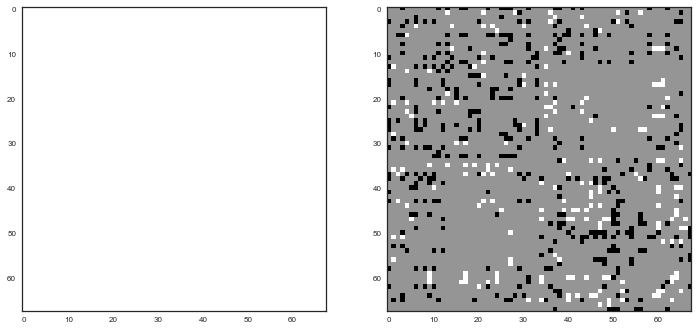

In [14]:
# plt.imshow(np.array(mix_results[-1][0].ms))
print(mix_shr_results[-1][0].hs)
print(mix_shr_results[-1][0].sigmasq_x)
# plt.subplot(121)
# plt.imshow(mix_results[-1][0].edge_probabilities(0))
# plt.subplot(122)
# plt.imshow(mix_results[-1][0].edge_probabilities(1))
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(mix_shr_results[-1][0].edge_probabilities(0) - mix_shr_results[-1][0].edge_probabilities(1))
plt.subplot(122)
plt.imshow(As[0].astype(float) - As[1].astype(float))

In [15]:
# Factorial latent space models
fac_models = []
for K in Ks:
    fac_models.append(
        FactorialLatentSpaceModel(V, K, sigmasq_b=sigmasq_b, alpha=1 + K / 2.0))
fac_results = fit_list(fac_models)

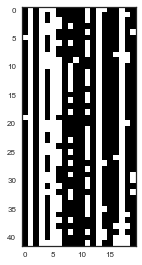

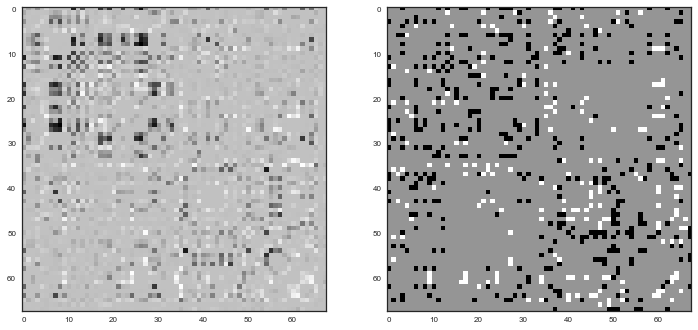

In [16]:
# plt.imshow(np.array(mix_results[-1][0].ms))
plt.figure()
plt.imshow(np.array(fac_results[-1][0].ms))


plt.figure(figsize=(12,8))
plt.subplot(121)
plt.imshow(fac_results[-1][0].edge_probabilities(0) - fac_results[-1][0].edge_probabilities(1))
plt.subplot(122)
plt.imshow(As[0].astype(float) - As[1].astype(float))

# Check convergence

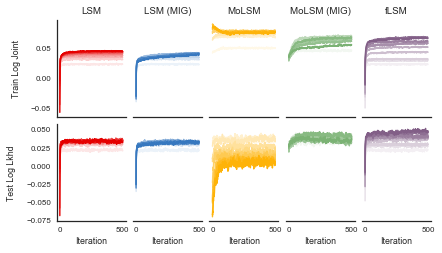

In [40]:
fig = plt.figure(figsize=(5.2, 2.8))
grid = Grid(fig, (0, 0, 1, 1), 
            nrows_ncols=(2, 5),
            axes_pad=0.1,
            add_all=True,
            label_mode="L",
            )

titles = ["LSM", "LSM (MIG)", "MoLSM", "MoLSM (MIG)", "fLSM"]

# Top row: Train log joint vs iteration
for j, results in \
    enumerate([std_results, std_shr_results, 
               mix_results, 
               mix_shr_results,
               fac_results
              ]):

    # Plot training log joint
    axj = grid[j]
    for K, (model, lprs, lls, _, _) in zip(Ks, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
#         axj.plot(np.arange(N_itr), (lprs + lls - baseline_ll) / N_train, color=color)
        axj.plot(np.arange(N_itr), (lls - baseline_ll) / N_train, color=color)
        axj.set_title(titles[j])
        
        axj.spines['top'].set_visible(False)
        axj.spines['right'].set_visible(False)
        if j > 0:
            axj.spines['left'].set_visible(False)
        else:
            axj.set_ylabel("Train Log Joint", labelpad=10)

# Bottom row: Test likelihood vs iteration
for j, results in \
    enumerate([std_results, std_shr_results, 
               mix_results, 
               mix_shr_results,
               fac_results
              ]):

    # Plot test log likelihoods
    axj = grid[5 + j]
    for K, (model, _, _, hlls, _) in zip(Ks, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.plot(np.arange(N_itr), (hlls - baseline_hll) / N_test, color=color)
        
        axj.spines['top'].set_visible(False)
        axj.spines['right'].set_visible(False)
        if j > 0:
            axj.spines['left'].set_visible(False)
        else:
            axj.set_ylabel("Test Log Lkhd", labelpad=10)
        
        axj.set_xlabel("Iteration")
        
        
plt.savefig(os.path.join(results_dir, "convergence.pdf"))
plt.savefig(os.path.join(results_dir, "convergence.png"), dpi=300)

# Plot likelihood of train and test data
We see that the mixture of LSMs overfits the training data in the absence of a strong, sparsity-inducing prior.  With the prior, its predictive performance is comparable to that of the standard LSM.  The factorial model, by contrast, achieves significantly better predictive performance without suffering from overfitting.

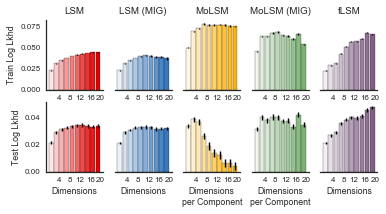

In [18]:
fig = plt.figure(figsize=(5.2, 2.8))
gs = gridspec.GridSpec(2, 5)

# Initialize the axes with sharing
axs = np.zeros((2, 5), dtype=object)
for j in range(5):
    sharey = None if j == 0 else axs[1,0]
    axs[1,j] = fig.add_subplot(gs[1,j], sharey=sharey)
for j in range(5):
    sharey = None if j == 0 else axs[0,0]
    axs[0,j] = fig.add_subplot(gs[0,j], sharex=axs[1,j], sharey=sharey)
    
titles = ["LSM", "LSM (MIG)", "MoLSM", "MoLSM (MIG)", "fLSM"]

# Top row: train log likelihood
for j, results in \
    enumerate([std_results, 
               std_shr_results, 
               mix_results, 
               mix_shr_results,
               fac_results
              ]):
        
    axj = axs[0,j]
    for K, (_, lprs, lls, _, _) in zip(Ks, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.bar(K, (np.mean(lls[N_itr // 2:]) - baseline_ll) / N_train, 
                yerr=np.std(lls[N_itr // 2:]) / N_train,  
                width=1.8, color=color, ecolor='k', edgecolor='k')
    
    axj.set_title(titles[j])
    
    # Remove spines
    axj.set_xticks([])
    axj.spines['top'].set_visible(False)
    axj.spines['right'].set_visible(False)
    if j > 0:
        axj.spines['left'].set_visible(False)
        plt.setp(axj.get_yticklabels(), visible=False)
    else:
        axj.set_ylabel("Train Log Lkhd")
    
    
# Bottom row: test log likelihood
for j, results in \
    enumerate([std_results, 
               std_shr_results, 
               mix_results, 
               mix_shr_results,
               fac_results
              ]):
    
    axj = axs[1,j]
    for K, (_, _, _, hlls, _) in zip(Ks, results):
        color = white_to_color_cmap(colors[j])(K / Ks[-1])
        axj.bar(K, (np.mean(hlls[N_itr // 2:]) - baseline_hll) / N_test,
                yerr=np.std(hlls[N_itr // 2:]) / N_test,  
                width=1.8, color=color, ecolor='k', edgecolor='k')
        
    # Plot zero line
    axj.plot([Ks[0]-2, Ks[-1]+2], [0, 0], '-k', lw=0.5)
    
    # Configure x axis
    axj.set_xlim(Ks[0]-2, Ks[-1]+2)
    axj.set_xticks(np.arange(4, 21, 4)+1)
    axj.set_xticklabels(np.arange(4, 21, 4))
    
    if titles[j].startswith("Mo"):
        axj.set_xlabel("Dimensions\nper Component")
    else:
        axj.set_xlabel("Dimensions")
    
    # Remove spines
    axj.spines['top'].set_visible(False)
    axj.spines['right'].set_visible(False)
    if j > 0:
        axj.spines['left'].set_visible(False)
        plt.setp(axj.get_yticklabels(), visible=False)
    else:
        axj.set_ylabel("Test Log Lkhd")
        
plt.tight_layout(pad=0.1)
plt.savefig(os.path.join(results_dir, "lls.pdf"))
plt.savefig(os.path.join(results_dir, "lls.png"), dpi=300)

In [19]:
print("Baseline train pr per edge: ", np.exp(baseline_ll / N_train))
print("Factorial train pr per edge: ", np.exp(baseline_ll / N_train + 0.08))

print("Baseline test pr per edge: ", np.exp(baseline_hll / N_test))
print("Factorial test pr per edge: ", np.exp(baseline_hll / N_test + 0.05))

Baseline train pr per edge:  0.778379444075
Factorial train pr per edge:  0.843208385511
Baseline test pr per edge:  0.765814312482
Factorial test pr per edge:  0.805078451903


# Look at the inferred factors

In [22]:
# Get the fit fLSM model for K=20
fac_lsm_K20 = fac_results[-1][0]

# Sort factors by variance (for used columns only)
M = np.array(fac_lsm_K20.ms)
used = M.sum(0) > 0
N_used = np.sum(used)
lmbda = np.var(fac_lsm_K20.X, axis=0)
perm = np.argsort(lmbda * used)[::-1]

# Get the rank one factors
X = fac_lsm_K20.X[:,perm]
XXTs = np.array([np.outer(X[:,k], X[:,k].T) for k in range(fac_lsm_K20.K)])
for XXTj in XXTs:
    np.fill_diagonal(XXTj, 0)
lim = np.max(abs(XXTs[:10]))

# Get the mean network
Amean = As.mean(0)
np.fill_diagonal(Amean, 0)

# Get the bias
b_fac = logistic(fac_lsm_K20.b)

In [23]:
# Exaggerate the colormap by pushing values toward lim
logistic = lambda u: 1 / (1 + np.exp(-u))
logit = lambda p: np.log(p / (1-p))
class LogisticNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False, lim=1, scale=3.0):
        self.lim = lim
        self.scale = scale
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        z = (value + self.lim) / (2 * self.lim)
        zhat = logistic(self.scale * logit(z))
        return np.ma.masked_array(zhat)


Unfortunately the colorbar shrinks the subplot... what to do?

/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/scott/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


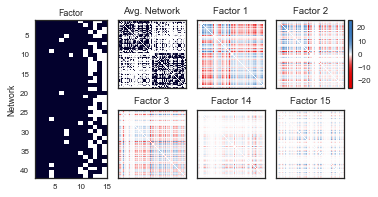

In [26]:
fig = plt.figure(figsize=(5.2,2.8))

# Plot the factor usage
ax0 = create_axis_at_location(fig, 0.4, 0.4, 1., 2.2 )
dark_cmap = white_to_color_cmap(colors[-1])
ax0.imshow(M[:,perm[:N_used]], interpolation="nearest", aspect="auto", 
           extent=(1,N_used,N,1), cmap=dark_cmap)
ax0.set_ylabel("Network")
ax0.set_xlabel("Factor")
ax0.xaxis.set_label_position('top') 

# Plot the average network
ax1 = create_axis_at_location(fig, 1.55, 1.65, .95, .95 )
ax1.imshow(Amean, vmin=0, vmax=1, interpolation="nearest", cmap=dark_cmap)
ax1.set_title("Avg. Network")
ax1.set_xticks([])
ax1.set_yticks([])

# Plot the outer product of individual factors
factors_to_plot = [0, 1, 2, 13, 14]
cmap = gradient_cmap([colors[0], np.ones(3), colors[1]])
for j in range(2):
    axj = create_axis_at_location(fig, 2.65 + 1.1 * j, 1.65, .95, .95 )
    im = axj.imshow(XXTs[factors_to_plot[j]], 
                    interpolation="nearest", 
                    vmin=-lim, vmax=lim, cmap=cmap, 
                    norm=LogisticNormalize(lim=lim, scale=3))
    axj.set_xticks([])
    axj.set_yticks([])
    axj.set_title("Factor {}".format(factors_to_plot[j]+1))

# Plot colorbar
ax_cb = create_axis_at_location(fig, 4.75, 1.65, 0.05, .95)
plt.colorbar(im, cax=ax_cb)
    
for j in range(2, 5):
    axj = create_axis_at_location(fig, 1.55 + 1.1 * (j-2), .4, .95, .95 )
    axj.imshow(XXTs[factors_to_plot[j]], 
               interpolation="nearest", 
               vmin=-lim, vmax=lim, cmap=cmap, 
               norm=LogisticNormalize(lim=lim, scale=3))
    axj.set_xticks([])
    axj.set_yticks([])
    axj.set_title("Factor {}".format(factors_to_plot[j]+1))
                      
plt.savefig(os.path.join(results_dir, "factors.pdf"))
plt.savefig(os.path.join(results_dir, "factors.png"), dpi=300)

# Check out the MoLSM results

In [30]:
# Get the fit fLSM model for K=20
mix_lsm = mix_shr_results[-1][0]
mix_lsm.sigmasq_x

array([  2.93154855e-01,   6.78501953e-02,   9.44418045e-03,
         5.91832914e-03,   4.20340569e-03,   1.22903366e-03,
         2.06608986e-04,   8.25609970e-05,   4.35009331e-05,
         1.04757805e-05,   3.74117999e-06,   1.10728975e-06,
         4.57098340e-07,   1.41686747e-07,   8.15218817e-08,
         3.55748330e-08,   8.15020205e-09,   8.67969626e-09,
         2.52033656e-09,   5.99603797e-10,   3.41172711e-01,
         1.43010993e-01,   4.47203026e-02,   2.02355678e-02,
         3.03157694e-03,   5.74814198e-04,   1.78363089e-04,
         6.61625140e-05,   2.05074842e-05,   1.21112040e-05,
         2.75950308e-06,   1.16167771e-06,   6.64942903e-07,
         1.77262387e-07,   5.49671814e-08,   6.26506851e-09,
         5.59866317e-09,   1.74147347e-09,   1.65226475e-09,
         3.35626905e-10,   3.07364070e+00,   5.07561991e+00,
         2.09867812e+00,   8.81596241e-01,   3.48660801e-01,
         8.13287064e-02,   2.67885122e-02,   6.32647315e-03,
         7.41651402e-04,

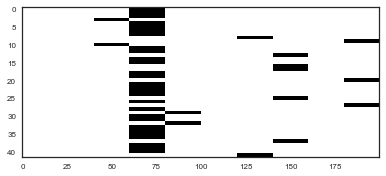

In [38]:
mix_lsm = mix_shr_results[-1][0]
# mix_lsm_ms0 = mix_results[-1][3][0]

# Sort factors by variance (for used columns only)
M = np.array(mix_lsm.ms)
# used = M.sum(0) > 0
# lmbda = np.var(mix_lsm.X, axis=0)

# # Get the rank one factors
# X = mix_lsm.X
# XXTs = np.array([np.outer(X[:,k], X[:,k].T) for k in range(mix_lsm.K)])
# for XXTj in XXTs:
#     np.fill_diagonal(XXTj, 0)
# lim = np.max(abs(XXTs[:10]))

plt.imshow(M, aspect=2.0)